In [1]:
#import necessary libraries
import numpy as np
import cv2 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from skimage.feature import hog
from skimage import color, exposure

import glob
import random
import time

from moviepy.editor import VideoFileClip 
from scipy.ndimage.measurements import label
from IPython.display import HTML
from functools import reduce

%matplotlib inline

In [2]:
#Load data
vehicles_images = glob.glob('./vehicles/*/*.png')
non_vehicles_images = glob.glob('./non-vehicles/*/*.png')

def data_loading(my_list):
    new_list = []
    for image in my_list:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_list.append(img)
    return new_list

cars = data_loading(vehicles_images)
non_cars = data_loading(non_vehicles_images)

index = 10
car = cars[index]
non_car = non_cars[index]
print('Number of car images: ', len(cars))
print('Number of non-car images: ', len(non_cars))

Number of car images:  8792
Number of non-car images:  8968


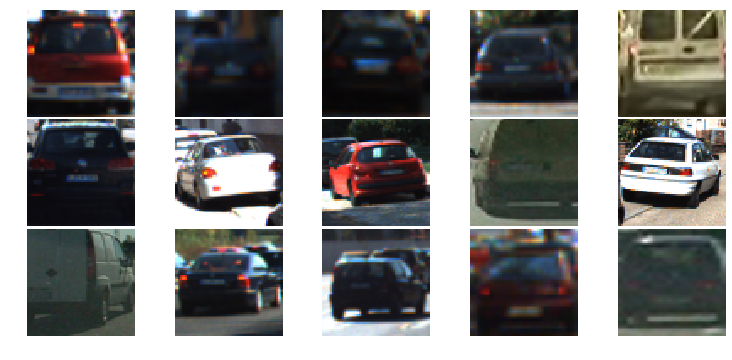

In [3]:
#Plot 15 random images

def image_generating(images):
    """
    Generate images
    """
    fig, axes = plt.subplots(3, 5, figsize=(13, 6))
    fig.subplots_adjust(left=None, right=None, hspace = .02, wspace=0.1)
    for i in range(3):
        for j in range(5):
            randomindex = random.randint(0, len(images) - 1) 
            axes[i,j].axis('off')
            axes[i,j].imshow(images[randomindex])
            
image_generating(cars)

# """Saving 2 sample images"""
# plt.imsave('./output_images/sample_car_img.jpg', cars[0])
# plt.imsave('./output_images/sample_non_car_img.jpg', non_cars[0])

In [4]:
# Feature Extraction

def bin_spatial(img, size=(32, 32)):
    """
    Define a function to compute binned color features  
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Define a function to compute color histogram features
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def getHogFeatures(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Define a function to get the HOG features
    """
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features


# Value object to hold all feature extraction parameters.
class featuresParameters():
    def __init__(self):
        # HOG parameters
        self.color_space = 'YCrCb'
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.spatial_size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)

def extract_features(image, params):
    """
    Define a function to extract features from a list of images
    """
    # Parameters extraction
    # HOG parameters
    color_space = params.color_space
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    spatial_size = params.spatial_size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
        

    # Call getHogFeatures() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(getHogFeatures(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = getHogFeatures(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, spatial_size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))

In [5]:
# Model Training

def fitModel(car, non_car, svc, scaler, params ):
    """
    Trains the classifier `svc`. The feature extraction is done using the parameters stored in `params`.
    The feature scalling is done by the scaler `scaler`.
    Returns: (`svc`, fittingTime, accuracy)
    """
    car_features = list(map(lambda img: extract_features(img, params), car))
    non_car_features = list(map(lambda img: extract_features(img, params), non_car))
    
    # Stacking and scaling
    X = np.vstack((car_features, non_car_features)).astype(np.float64)    
    X_scaler = scaler.fit(X)
    scaled_X = X_scaler.transform(X)
    
    # Defining objective
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Fitting
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    fittingTime = round(t2 - t, 2)
    accuracy = round(svc.score(X_test, y_test),4)
    return (svc, X_scaler, fittingTime, accuracy)

In [6]:
params = featuresParameters()
svc, scaler, fittingTime, accuracy = fitModel(cars, non_cars, LinearSVC(), StandardScaler(), params)
print('Fitting time: {} s, Accuracy: {}'.format(fittingTime, accuracy))

Fitting time: 11.79 s, Accuracy: 0.9938


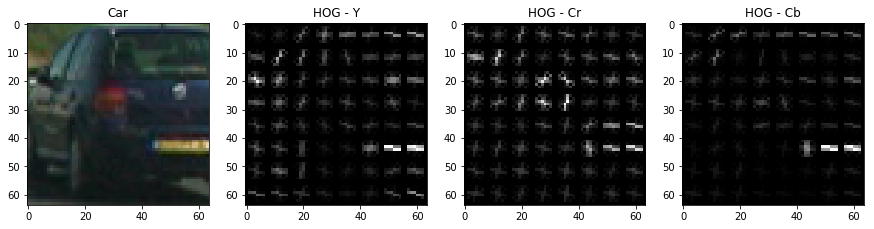

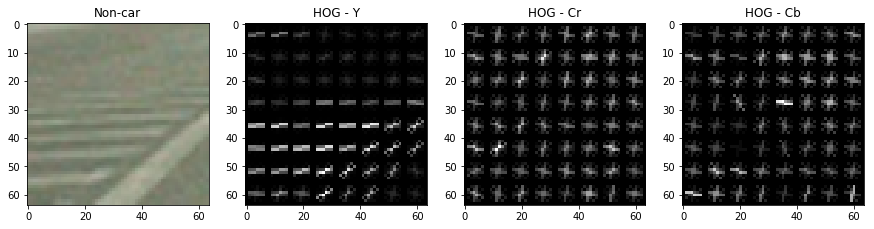

In [7]:
# HOG images from training
def displayHog(img, title):
    """
    Calculate HOG on the image `img` and the YCrCb color space and show them on a graph.
    """
    img_color_spaced = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    _, hog_y = getHogFeatures(img_color_spaced[:,:,0], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cr = getHogFeatures(img_color_spaced[:,:,1], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cb = getHogFeatures(img_color_spaced[:,:,2], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')

displayHog(car, 'Car')
displayHog(non_car, 'Non-car')


In [8]:
# Slide Window

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Create a rectangle to draw the vehicles detected
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [9]:
test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), glob.glob('./test_images/*.jpg')))

In [10]:
def findCarWindows(img, clf, scaler, params, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars boxes.
    """
    car_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

def drawCars(img, windows):
    """
    Draw the `windows` on the image `img`.
    """
    output = np.copy(img)
    return draw_boxes(output, windows)

In [11]:
car_on_test = list(map(lambda img: drawCars(img, findCarWindows(img, svc, scaler, params)), test_images))

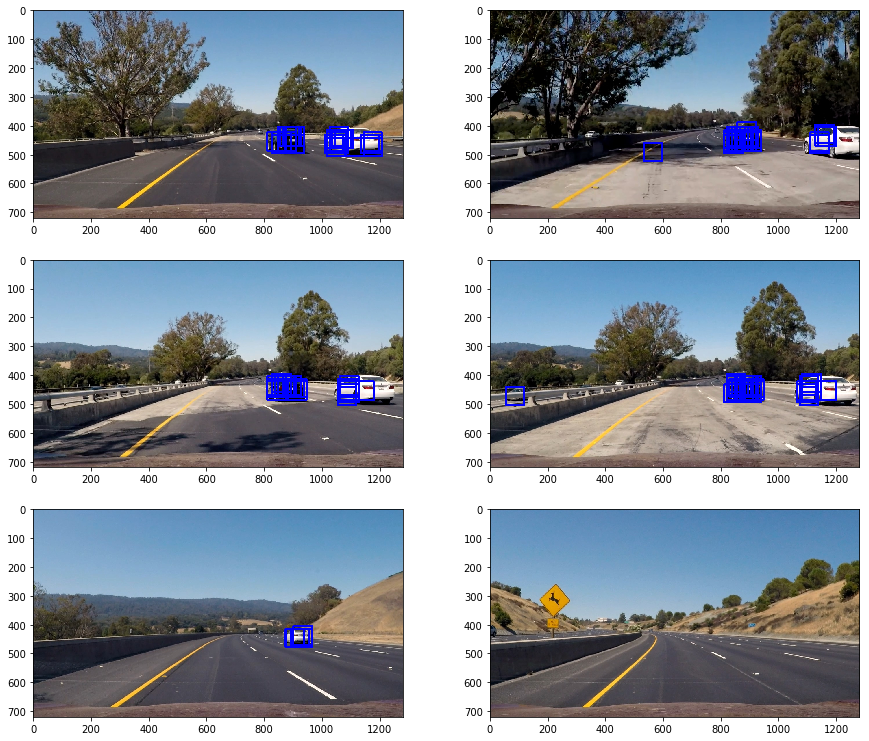

In [12]:
def display(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            image = images[index]
            ax.imshow(image)
            plt.savefig('./output_images/sliding.jpg')
            
display(car_on_test)

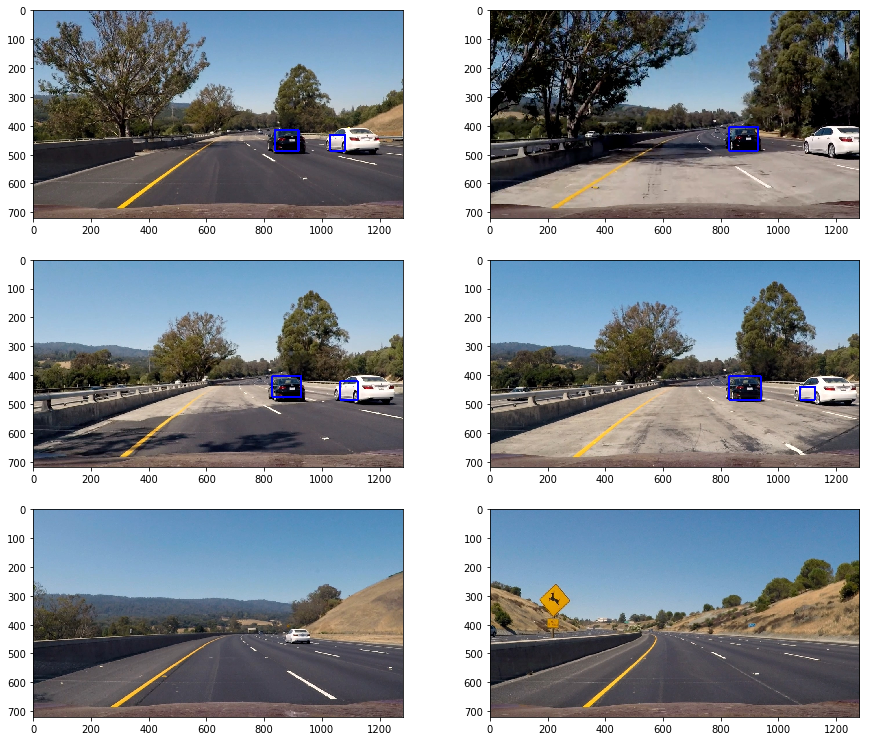

In [35]:
# Heat map and labels

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def drawCarsWithLabels(img, boxes, threshHold = 4):
    """
    Draw the car boxes `boxes` on the image `img` using a heatmap with threshold `threshHold`.
    """
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap = apply_threshold(heatmap, threshHold)
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(img), labels)
    
boxed_on_test = list(map(lambda img: drawCarsWithLabels(img, findCarWindows(img, svc, scaler, params)), test_images))

display(boxed_on_test)

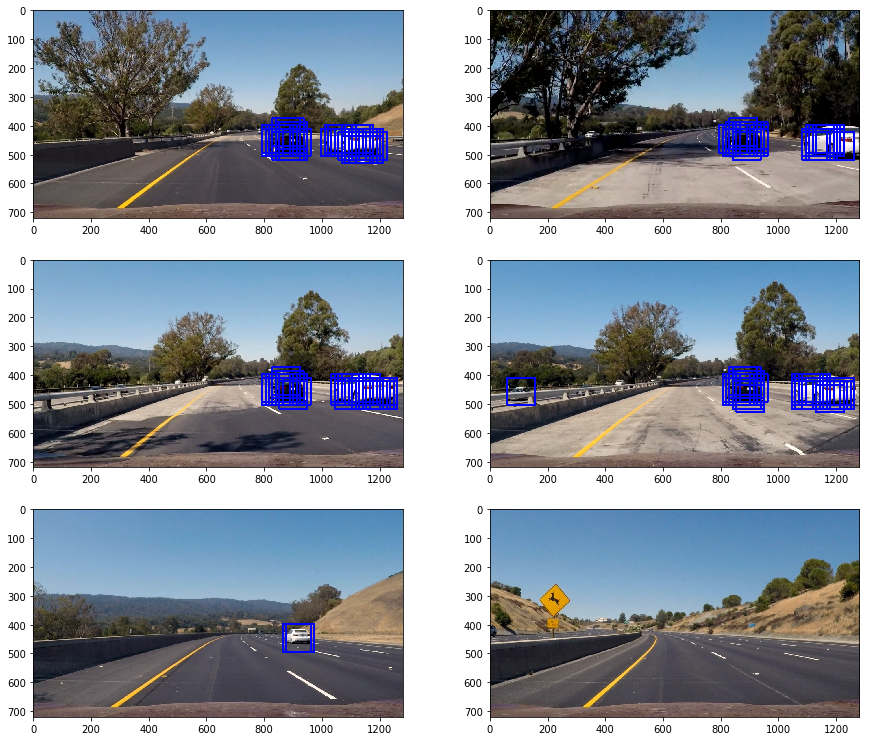

In [36]:
# Improve performance with HOG sub-sampling

def findCars(img, clf, scaler, params, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5 ):   
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `window` : Number of windows.
    `cells_per_step` : Number of cells per step.
    Returns a new image with the cars boxes.
    """
    # Parameters extraction
    # HOG parameters
    color_space = params.color_space
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    spatial_size = params.spatial_size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            
    else: 
        feature_image = np.copy(img)
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
     # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = getHogFeatures(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = getHogFeatures(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = getHogFeatures(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    

    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size) 
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

fast_boxes = list(map(lambda img: findCars(img, svc, scaler, params), test_images))

fast_on_test = list(map(lambda imgAndBox: drawCars(imgAndBox[0], imgAndBox[1]), zip(test_images, fast_boxes)))

display(fast_on_test)

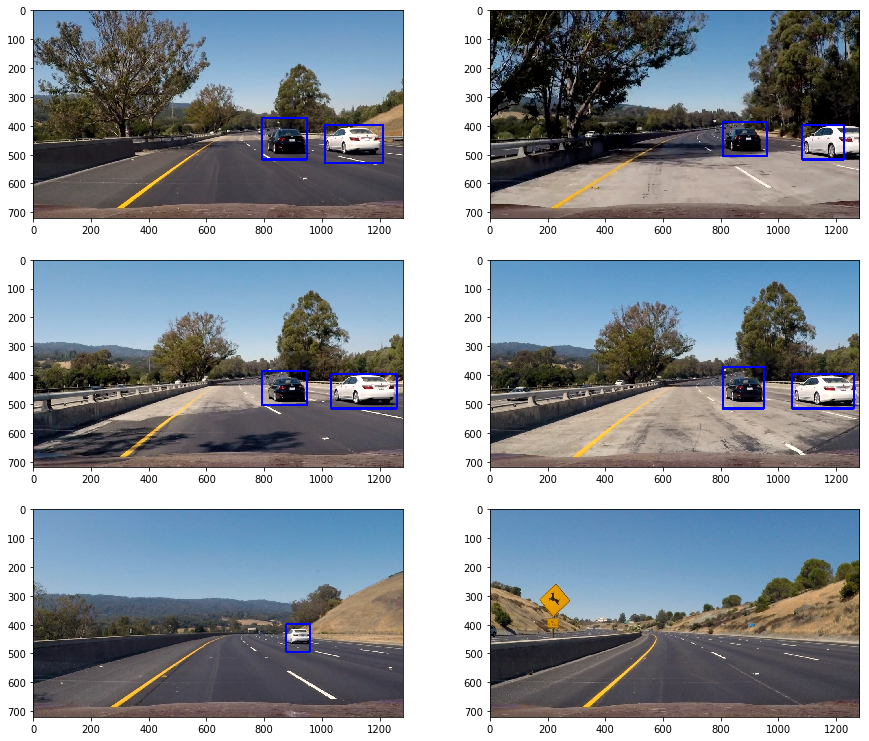

In [37]:
fast_on_test = list(map(lambda imgAndBox: drawCarsWithLabels(imgAndBox[0], imgAndBox[1], threshHold=1), zip(test_images, fast_boxes)))

display(fast_on_test)

In [30]:
#Test on video

class HeatHistory():
    def __init__(self):
        self.history = []
        
def video_processing(input, output, frames_to_remember=3, threshhold=1):
    """
    Process the video `input` to find the cars and saves the video to `output`.
    """
    history = HeatHistory()

    def pipeline(img):
        boxes = findCars(img, svc, scaler, params)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= frames_to_remember:
            history.history = history.history[1:]

        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(input)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(output, audio=False)
    
video_processing('./project_video.mp4', './output_videos/project_video.mp4', threshhold=2)
    

                                                                
t:   4%|▍         | 49/1260 [30:56<8:30:07, 25.27s/it, now=None]
                                                                A
t:   4%|▎         | 46/1260 [01:22<31:58,  1.58s/it, now=None]

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output_videos/project_video.mp4.
Moviepy - Writing video ./output_videos/project_video.mp4





t:   0%|          | 2/1260 [00:01<16:42,  1.25it/s, now=None]

t:   0%|          | 3/1260 [00:03<22:09,  1.06s/it, now=None]

t:   0%|          | 4/1260 [00:04<25:04,  1.20s/it, now=None]

t:   0%|          | 5/1260 [00:06<28:32,  1.36s/it, now=None]

t:   0%|          | 6/1260 [00:08<30:28,  1.46s/it, now=None]

t:   1%|          | 7/1260 [00:09<32:03,  1.53s/it, now=None]

t:   1%|          | 8/1260 [00:11<32:52,  1.58s/it, now=None]

t:   1%|          | 9/1260 [00:13<32:35,  1.56s/it, now=None]

t:   1%|          | 10/1260 [00:14<33:38,  1.61s/it, now=None]

t:   1%|          | 11/1260 [00:16<33:58,  1.63s/it, now=None]

t:   1%|          | 12/1260 [00:18<34:22,  1.65s/it, now=None]

t:   1%|          | 13/1260 [00:19<33:45,  1.62s/it, now=None]

t:   1%|          | 14/1260 [00:21<35:53,  1.73s/it, now=None]

t:   1%|          | 15/1260 [00:23<37:17,  1.80s/it, now=None]

t:   1%|▏         | 16/1260 [00:25<38:04,  1.84s/it, now=None]

t:   1%|▏         | 17/1260 [00:27<37:10,  1.7

KeyboardInterrupt: 

In [33]:
def heat_threshold(img, threshold, svc, scaler, xy_window, params):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,xy_window)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

def pipeline(img):
    ystart = 350
    ystop = 656
    threshold = 1 
    car_windows = findCars(img, svc, scaler, params)
    draw_img, heat_map = heat_threshold(img, threshold, svc, scaler, car_windows, params)
    
    return draw_img

In [34]:
def process_image(img):
    return pipeline(img)

white_output = './output_videos/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

                                                                

                                                        
t:   4%|▍         | 49/1260 [40:09<8:30:07, 25.27s/it, now=None]

t:   3%|▎         | 40/1260 [09:12<35:18,  1.74s/it, now=None]
                                                                A

                                                        
t:   4%|▍         | 49/1260 [40:09<8:30:07, 25.27s/it, now=None]

t:   4%|▎         | 46/1260 [10:35<31:58,  1.58s/it, now=None]


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output_videos/project_video.mp4.
Moviepy - Writing video ./output_videos/project_video.mp4






t:   0%|          | 2/1260 [00:01<16:08,  1.30it/s, now=None]


t:   0%|          | 3/1260 [00:03<20:28,  1.02it/s, now=None]


t:   0%|          | 4/1260 [00:04<23:19,  1.11s/it, now=None]


t:   0%|          | 5/1260 [00:05<26:07,  1.25s/it, now=None]


t:   0%|          | 6/1260 [00:07<26:53,  1.29s/it, now=None]


t:   1%|          | 7/1260 [00:08<28:35,  1.37s/it, now=None]


t:   1%|          | 8/1260 [00:10<30:00,  1.44s/it, now=None]


t:   1%|          | 9/1260 [00:12<31:17,  1.50s/it, now=None]


t:   1%|          | 10/1260 [00:13<31:48,  1.53s/it, now=None]


t:   1%|          | 11/1260 [00:15<31:49,  1.53s/it, now=None]


t:   1%|          | 12/1260 [00:16<32:08,  1.55s/it, now=None]


t:   1%|          | 13/1260 [00:18<31:36,  1.52s/it, now=None]


t:   1%|          | 14/1260 [00:19<31:10,  1.50s/it, now=None]


t:   1%|          | 15/1260 [00:21<30:52,  1.49s/it, now=None]


t:   1%|▏         | 16/1260 [00:22<31:27,  1.52s/it, now=None]


t:   1%|▏         | 17/1260 [0

t:  18%|█▊        | 221/1260 [05:16<23:51,  1.38s/it, now=None]


t:  18%|█▊        | 222/1260 [05:17<23:53,  1.38s/it, now=None]


t:  18%|█▊        | 223/1260 [05:18<23:46,  1.38s/it, now=None]


t:  18%|█▊        | 224/1260 [05:20<23:45,  1.38s/it, now=None]


t:  18%|█▊        | 225/1260 [05:21<23:48,  1.38s/it, now=None]


t:  18%|█▊        | 226/1260 [05:23<23:46,  1.38s/it, now=None]


t:  18%|█▊        | 227/1260 [05:24<23:43,  1.38s/it, now=None]


t:  18%|█▊        | 228/1260 [05:25<23:38,  1.37s/it, now=None]


t:  18%|█▊        | 229/1260 [05:27<23:36,  1.37s/it, now=None]


t:  18%|█▊        | 230/1260 [05:28<23:32,  1.37s/it, now=None]


t:  18%|█▊        | 231/1260 [05:29<23:29,  1.37s/it, now=None]


t:  18%|█▊        | 232/1260 [05:31<23:25,  1.37s/it, now=None]


t:  18%|█▊        | 233/1260 [05:32<23:31,  1.37s/it, now=None]


t:  19%|█▊        | 234/1260 [05:34<23:26,  1.37s/it, now=None]


t:  19%|█▊        | 235/1260 [05:35<23:33,  1.38s/it, now=None]


t:  19%|█▊

t:  35%|███▍      | 439/1260 [10:18<18:54,  1.38s/it, now=None]


t:  35%|███▍      | 440/1260 [10:19<18:51,  1.38s/it, now=None]


t:  35%|███▌      | 441/1260 [10:21<18:47,  1.38s/it, now=None]


t:  35%|███▌      | 442/1260 [10:22<18:49,  1.38s/it, now=None]


t:  35%|███▌      | 443/1260 [10:23<18:48,  1.38s/it, now=None]


t:  35%|███▌      | 444/1260 [10:25<18:43,  1.38s/it, now=None]


t:  35%|███▌      | 445/1260 [10:26<18:38,  1.37s/it, now=None]


t:  35%|███▌      | 446/1260 [10:27<18:39,  1.38s/it, now=None]


t:  35%|███▌      | 447/1260 [10:29<18:43,  1.38s/it, now=None]


t:  36%|███▌      | 448/1260 [10:30<18:41,  1.38s/it, now=None]


t:  36%|███▌      | 449/1260 [10:32<18:38,  1.38s/it, now=None]


t:  36%|███▌      | 450/1260 [10:33<18:35,  1.38s/it, now=None]


t:  36%|███▌      | 451/1260 [10:34<18:36,  1.38s/it, now=None]


t:  36%|███▌      | 452/1260 [10:36<18:32,  1.38s/it, now=None]


t:  36%|███▌      | 453/1260 [10:37<18:34,  1.38s/it, now=None]


t:  36%|██

t:  52%|█████▏    | 657/1260 [15:22<14:49,  1.48s/it, now=None]


t:  52%|█████▏    | 658/1260 [15:23<14:37,  1.46s/it, now=None]


t:  52%|█████▏    | 659/1260 [15:25<14:20,  1.43s/it, now=None]


t:  52%|█████▏    | 660/1260 [15:26<14:07,  1.41s/it, now=None]


t:  52%|█████▏    | 661/1260 [15:28<14:01,  1.40s/it, now=None]


t:  53%|█████▎    | 662/1260 [15:29<13:54,  1.40s/it, now=None]


t:  53%|█████▎    | 663/1260 [15:30<13:51,  1.39s/it, now=None]


t:  53%|█████▎    | 664/1260 [15:32<13:48,  1.39s/it, now=None]


t:  53%|█████▎    | 665/1260 [15:33<13:43,  1.38s/it, now=None]


t:  53%|█████▎    | 666/1260 [15:34<13:39,  1.38s/it, now=None]


t:  53%|█████▎    | 667/1260 [15:36<13:59,  1.42s/it, now=None]


t:  53%|█████▎    | 668/1260 [15:37<14:00,  1.42s/it, now=None]


t:  53%|█████▎    | 669/1260 [15:39<13:50,  1.40s/it, now=None]


t:  53%|█████▎    | 670/1260 [15:40<13:43,  1.40s/it, now=None]


t:  53%|█████▎    | 671/1260 [15:42<13:42,  1.40s/it, now=None]


t:  53%|██

t:  69%|██████▉   | 875/1260 [20:25<08:55,  1.39s/it, now=None]


t:  70%|██████▉   | 876/1260 [20:26<08:53,  1.39s/it, now=None]


t:  70%|██████▉   | 877/1260 [20:28<08:50,  1.38s/it, now=None]


t:  70%|██████▉   | 878/1260 [20:29<08:46,  1.38s/it, now=None]


t:  70%|██████▉   | 879/1260 [20:30<08:45,  1.38s/it, now=None]


t:  70%|██████▉   | 880/1260 [20:32<08:42,  1.37s/it, now=None]


t:  70%|██████▉   | 881/1260 [20:33<08:39,  1.37s/it, now=None]


t:  70%|███████   | 882/1260 [20:34<08:37,  1.37s/it, now=None]


t:  70%|███████   | 883/1260 [20:36<08:36,  1.37s/it, now=None]


t:  70%|███████   | 884/1260 [20:37<08:35,  1.37s/it, now=None]


t:  70%|███████   | 885/1260 [20:39<08:36,  1.38s/it, now=None]


t:  70%|███████   | 886/1260 [20:40<08:35,  1.38s/it, now=None]


t:  70%|███████   | 887/1260 [20:41<08:36,  1.39s/it, now=None]


t:  70%|███████   | 888/1260 [20:43<08:33,  1.38s/it, now=None]


t:  71%|███████   | 889/1260 [20:44<08:33,  1.38s/it, now=None]


t:  71%|██

t:  87%|████████▋ | 1092/1260 [25:26<03:49,  1.37s/it, now=None]


t:  87%|████████▋ | 1093/1260 [25:27<03:48,  1.37s/it, now=None]


t:  87%|████████▋ | 1094/1260 [25:29<03:47,  1.37s/it, now=None]


t:  87%|████████▋ | 1095/1260 [25:30<03:45,  1.37s/it, now=None]


t:  87%|████████▋ | 1096/1260 [25:31<03:44,  1.37s/it, now=None]


t:  87%|████████▋ | 1097/1260 [25:33<03:42,  1.37s/it, now=None]


t:  87%|████████▋ | 1098/1260 [25:34<03:41,  1.37s/it, now=None]


t:  87%|████████▋ | 1099/1260 [25:35<03:39,  1.37s/it, now=None]


t:  87%|████████▋ | 1100/1260 [25:37<03:38,  1.37s/it, now=None]


t:  87%|████████▋ | 1101/1260 [25:38<03:38,  1.37s/it, now=None]


t:  87%|████████▋ | 1102/1260 [25:40<03:36,  1.37s/it, now=None]


t:  88%|████████▊ | 1103/1260 [25:41<03:35,  1.37s/it, now=None]


t:  88%|████████▊ | 1104/1260 [25:42<03:34,  1.38s/it, now=None]


t:  88%|████████▊ | 1105/1260 [25:44<03:32,  1.37s/it, now=None]


t:  88%|████████▊ | 1106/1260 [25:45<03:31,  1.38s/it, now=Non

Moviepy - Done !
Moviepy - video ready ./output_videos/project_video.mp4
CPU times: user 28min 44s, sys: 22.5 s, total: 29min 6s
Wall time: 29min 29s
